In [4]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("rhdf5")
BiocManager::install("clusterProfiler", dependencies = TRUE, INSTALL_opts = '--no-lock')
BiocManager::install("pathview")
BiocManager::install("enrichplot")
BiocManager::install('EnhancedVolcano')
BiocManager::install('ComplexHeatmap')

library(clusterProfiler)
library(enrichplot)
library(ggplot2)
library(tximport)
library(DESeq2)
library(tidyverse)
library(cowplot)
library(rhdf5)
library(EnhancedVolcano)
library(ComplexHeatmap)
library(data.table)
library(ggrepel)

Bioconductor version '3.17' is out-of-date; the current release version '3.18'
  is available with R version '4.3'; see https://bioconductor.org/install

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.17 (BiocManager 1.30.22), R 4.3.2 (2023-10-31)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'rhdf5'”
Old packages: 'bbmle', 'BH', 'brio', 'coda', 'commonmark', 'cowplot',
  'data.table', 'DBI', 'dbplyr', 'DelayedArray', 'desc', 'DT', 'filelock',
  'GenomeInfoDb', 'GenomicRanges', 'ggfun', 'graphlayouts', 'haven', 'httpuv',
  'igraph', 'lattice', 'MASS', 'Matrix', 'MatrixGenerics', 'matrixStats',
  'mgcv', 'mvtnorm', 'nlme', 'patchwork', 'pbdZMQ', 'pkgbuild', 'pkgload',
  'processx', 'progress', 'ps', 'ragg', 'RcppEigen', 'RCurl', 'readr',

In [ ]:
t2g <- read_tsv("t2g.tsv", col_names = c("transcript_id", "gene_id", "gene_name"))

In [ ]:
g2name <- t2g %>%
    select(-transcript_id) %>%
    distinct()

In [ ]:
samples <- read_csv("samples.csv")

In [ ]:
samples <- samples %>% mutate(path = file.path(folder, file, "abundance.tsv"))

In [ ]:
txi <- tximport (files = samples %>% select(sample, path) %>% deframe(),
                 type = "kallisto", 
                 tx2gene = t2g %>% select(transcript_id, gene_id),
                 ignoreTxVersion = T,
                 ignoreAfterBar = T)


In [ ]:
samples <- samples %>% as.data.frame() %>% column_to_rownames("sample") %>% select(condition)

In [ ]:
dds <- DESeqDataSetFromTximport(txi, samples, ~ condition)
dds <- dds[rowSums(counts(dds, normalized = F)) > 3, ]

In [ ]:
dds
dim(dds)

In [ ]:
qc <- vst(dds,blind = T)

In [ ]:
plotPCA(qc, intgroup = "condition")

In [ ]:
dds <- DESeq(dds, fitType = "parametric", minReplicatesForReplace = 7, betaPrior = F, parallel = F)
rld <- rlog(dds, blind = F)


In [ ]:
counts = assay(rld) %>% 
as.data.frame() %>% 
rownames_to_column("gene_id")

In [ ]:
for(i in c("LHA4")) {
    res <- results(dds, alpha = 0.05, contrast = c("condition", i, "dCAS9"), parallel = F)
    res <- res %>% 
    as.data.frame() %>% 
    rownames_to_column("gene_id") %>% 
    as_tibble()%>%
    arrange(pvalue)%>%
    left_join(g2name, by="gene_id") %>%
    relocate("gene_name", .before="gene_id") %>%
    add_column(counts = "") %>%
    left_join(counts, by="gene_id")
    res %>% write_csv(file = paste("dCAS9.vs.", i , ".csv", sep = ""))
}


In [ ]:
counts %>% left_join(g2name, by="gene_id") %>% 
relocate("gene_name", .after="gene_id") %>%
write_csv(file = "counts.csv") 

# Cluster Profiler

In [ ]:
# SET THE DESIRED ORGANISM HERE
organism = "org.Hs.eg.db"
BiocManager::install(organism, character.only = TRUE)
library(organism, character.only = TRUE)

In [ ]:
# reading in data from deseq2
df = read.csv("one.vs.two.csv", header=TRUE)

# we want the log2 fold change 
original_gene_list <- $log2FoldChange

# name the vector
names(original_gene_list) <- df$gene_id

# omit any NA values 
gene_list<-na.omit(original_gene_list)

# sort the list in decreasing order (required for clusterProfiler)
gene_list = sort(gene_list, decreasing = TRUE)

In [ ]:
gse <- gseGO(geneList=gene_list, 
             ont ="BP", 
             keyType = "ENSEMBL", 
             minGSSize = 3, 
             maxGSSize = 800, 
             pvalueCutoff = 1, 
             verbose = TRUE, 
             OrgDb = organism, 
             pAdjustMethod = "bonferroni")

In [ ]:
require(DOSE)
dotplot(gse, showCategory=10, split=".sign") + facet_grid(.~.sign)

In [ ]:
res <- read_csv("A188+B36.NT+RTTA.vs.A12.csv")
#png("NNvsRR_Volcano.png")
EnhancedVolcano(res,
    lab = res$gene_name,
    x = 'log2FoldChange',
    y = 'padj',
    pCutoff = 0.05,
    pointSize = 4.0,
    labSize = 4.0,
    labCol = 'black',
    legendLabSize = 14,
    legendIconSize = 4.0,
    drawConnectors = TRUE,
    widthConnectors = 1.0,
    colConnectors = 'black',
    labFace = 'bold',
    boxedLabels = TRUE,
    parseLabels = TRUE,
    max.overlaps = 30
    )
#dev.off()

# Heatmap

In [ ]:
counts <- read.csv("dCAS9.vs.LHA4.csv")
counts <- column_to_rownames(counts, var="gene_name")

In [ ]:
overlap <- read.csv("Overlap dCAS9 vs LHA4 and RR vs other.txt") %>% column_to_rownames(var="gene_name")

In [ ]:
counts <- counts[rownames(overlap),] %>% rownames_to_column(var="gene_name") %>% column_to_rownames(var="gene_id")

In [ ]:
mat <- counts(dds, normalized = T)[rownames(counts),]
mat.z <- t(apply(mat, 1, scale))
colnames(mat.z) <- rownames(samples)

In [ ]:
pdf("NNvsRR_Heatmap.pdf")
ht = Heatmap(mat.z, cluster_rows = T, cluster_columns = T, column_labels = colnames(mat.z), 
       name = "Z-score", row_labels = counts[rownames(mat.z),]$gene_name,
             width = ncol(mat)*unit(10, "mm"), height = ncol(mat)*unit(28, "mm"), row_names_gp = gpar(fontsize = 3)
            )
ht = draw(ht)
dev.off()

# Panther Table to Graph

In [6]:
#' Plot PantherDB enrichment/overrepresentation test result
#' @description Plot PantherDB enrichment/overrepresentation test result
#' @import data.table
#' @import ggplot2
#' @import ggrepel
#' @param PANTHERresult Panther result table path to .txt or data.table
#' @param p_cutoff Significance Cutoff for labelling the found terms in the plots 
#' @return A list of 1) the reformatted data.table, 2) scatter plot 3) barplot
#' @examples
#' plotPANTHERresult("panther_gocc.txt", p_cutoff = 0.05)
#' @export

plotPANTHERresult <- function(PANTHERresult = "panther_gocc.txt",
                              p_cutoff = 0.05){
  library(data.table)
  # define input
  if(class(PANTHERresult) == "character"){
    result <- fread(PANTHERresult)
  }
  
  # processing
  category <- names(result)[1]
  reflist <- names(result)[2]
  list <- names(result)[3]
  setnames(result, list, "in_list")
  setnames(result, category, "term")
  setnames(result, reflist, "in_reflist")
  result$category <- category 
  
  # clean up column names
  list <- strsplit(list, split = " ")[[1]][1]
  names(result)<- gsub(list, "", names(result))
  names(result) <- gsub(")", "", names(result))
  names(result) <- gsub(" \\(", "", names(result))
  names(result) <- gsub(" ", "_", names(result))
  names(result) <- gsub("\\-", "_", names(result))
  names(result) <- gsub("\\/", "_", names(result))
  
  # add list info columns
  result$list = list
  result$reflist = strsplit(reflist, split = " ")[[1]][1]

  
  # plotGoGraphs
  comparison_name <- paste0(gsub(".txt", "", unique(result$list)),
                            "_vs_",
                            gsub(".txt", "", unique(result$reflist)), 
                            "_", 
                            gsub(" ", "_", category))

  result <- result[term != "Unclassified (UNCLASSIFIED)"]
  result[, fold_Enrichment:=as.numeric(gsub("< ", "", fold_Enrichment))]
  result[, enrichment:=as.numeric(fold_Enrichment-1)]
  setorder(result, -enrichment)
  result <- result[!(is.na(enrichment))]
  result <- result[enrichment > 5]
    result <- result[P_value <= 0.005]
  result[, term_lean:=gsub(" \\(.*\\)", "", term)]$term_lean
  
  pdf(paste0(comparison_name, "_enrichment_scatter.pdf"), height = 10, width = 10)
  p = ggplot(result, aes(enrichment, -log10(P_value), label = term_lean, color = term_lean)) +
    geom_point(aes(size = in_list)) + geom_text_repel(data = result[P_value <= p_cutoff]) + theme_bw() + theme(legend.position = "none") +
    geom_vline(xintercept = 0, linetype = 1, size = 1, color = "black") + 
    geom_hline(yintercept = -log10(p_cutoff), linetype = 2, color = "grey")  +
    ggtitle(comparison_name)
  plot(p)
  dev.off()
  
  pdf(paste0(comparison_name, "_enrichment_bar.pdf"), height = 5, width = 5)
  q = ggplot(result, aes(x = reorder(term_lean, enrichment), enrichment, label = term_lean, fill = enrichment)) +
    geom_bar(stat = "identity") +
    coord_flip() +
    theme_bw() +
    theme(legend.position = "none") +
    scale_fill_continuous(low = "red", high = "blue") +
    geom_hline(yintercept = 0, linetype = 1, size = 1, color = "black") +
    xlab(unique(result$category)) +
    ylab("enrichment")
  plot(q)
  dev.off()
  
  return(list(table = result,
              scatterplot = p,
              barplot = q))
  
}

$table
                                                              term in_reflist
 1:          amino acid import across plasma membrane (GO:0089718)         37
 2: regulation of neural precursor cell proliferation (GO:2000177)        104
 3:                   canonical Wnt signaling pathway (GO:0060070)        110
 4:                     camera-type eye morphogenesis (GO:0048593)        131
 5: negative regulation of nervous system development (GO:0051961)        154
 6:                                 eye morphogenesis (GO:0048592)        159
 7:            regulation of fat cell differentiation (GO:0045598)        132
 8:                                     axon guidance (GO:0007411)        244
 9:                        neuron projection guidance (GO:0097485)        244
10:               negative regulation of neurogenesis (GO:0050768)        147
11:                                      gastrulation (GO:0007369)        170
12:                       sensory organ morphogenesis (GO

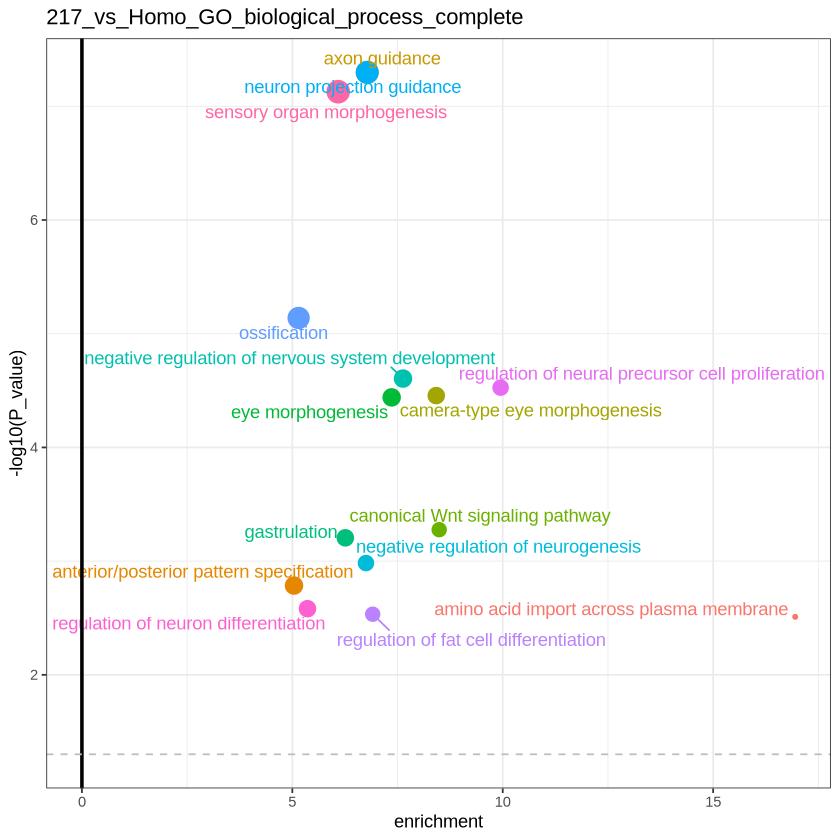

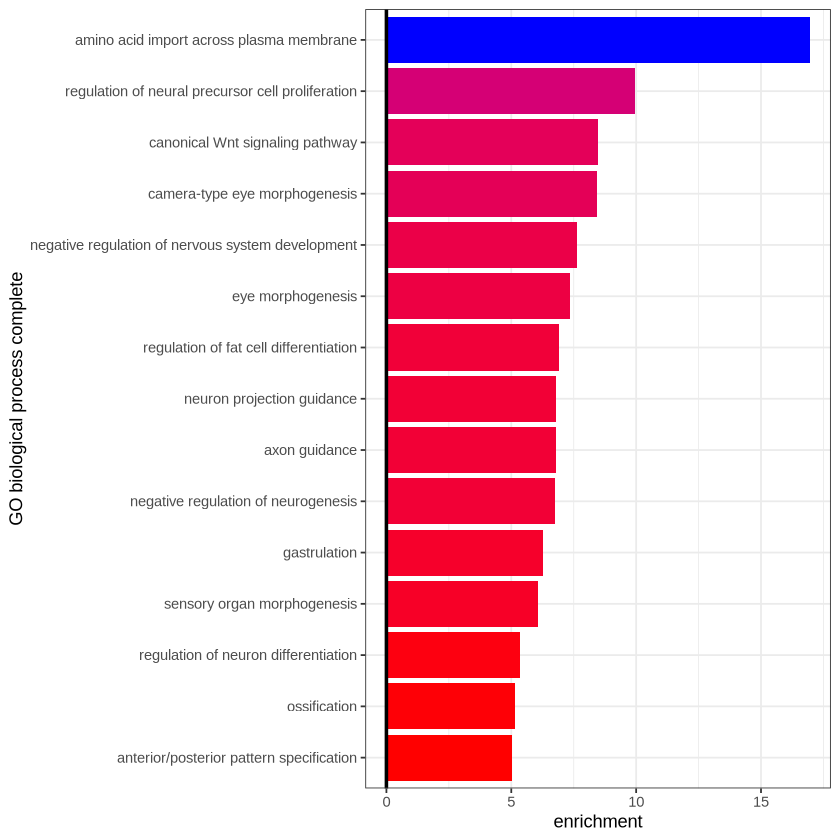

In [7]:

plotPANTHERresult(PANTHERresult = "dCAS9 vs LHA4 All Down.txt", p_cutoff = 0.05)
